# Import Libraries

In [225]:
# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [226]:
# Import libraries
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import squarify

# Import Dataset

In [227]:
df_orders = pd.read_csv('orders.csv', sep=';')
df_details = pd.read_csv('order_details.csv', sep=';')
df_products = pd.read_csv('products.csv', sep=';')
df_users = pd.read_csv('users.csv', sep=';')

In [228]:
df_merge = pd.merge(df_details, df_products, on='product_id', how='left')

In [229]:
#Sanity Check
df_merge.shape
df_merge.describe()
df_merge.info()
df_merge.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187452 entries, 0 to 187451
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   order_detail_id  187452 non-null  int64 
 1   order_id         187452 non-null  int64 
 2   product_id       187452 non-null  int64 
 3   price            187452 non-null  int64 
 4   quantity         187452 non-null  int64 
 5   desc_product     187452 non-null  object
 6   category         187452 non-null  object
 7   base_price       187452 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 12.9+ MB


(187452, 8)

# Data Pre-Process 

#### Merging

In [230]:
df_merge2 = pd.merge(df_merge, df_orders, on='order_id', how='inner')

In [231]:
df_merge2.head()

order_detail_id  order_id  product_id  price  quantity  \
0                5         3         907  25000        36   
1                9         5         562  10000        22   
2               15         8         645  39000        32   
3               48        19         287  22000        12   
4               49        19         201  26000        27   

                                        desc_product         category  \
0  Citra Fresh Glow Multifunction Gel Coconut Nou...  Kebersihan Diri   
1    Listerine Mouthwash Antiseptic Cool Mint 250Ml   Kebersihan Diri   
2                          808 Ayam Segar Utuh 900g        Fresh Food   
3                              Cip Corned Beef 198G    Makanan Kaleng   
4    Kraft Cheese Single High Calcium 5'S Plain 83G     Bahan Makanan   

   base_price  seller_id  buyer_id  kodepos  subtotal  discount    total  \
0       25000          5      4769    32610    900000         0   900000   
1       10000         23      4276     2674    220000         0   220000   
2       39000          4     14110    48577   1248000         0  1248000   
3       22000          5      3831    91235   1074000         0  1074000   
4       26000          5      3831    91235   1074000         0  1074000   

   created_at     paid_at delivery_at  
0  2019-06-01  2019-06-04  2019-06-12  
1  2019-04-02  2019-04-05  2019-04-09  
2  2019-08-02  2019-08-13  2019-08-20  
3  2020-05-16         NaN         NaN  
4  2020-05-16         NaN         NaN

#### Missing Value

In [232]:
#Na Handling
df_merge2.isnull().values.any()
df_merge2.isnull().values.sum()
df_merge2.isnull().sum()*100/df_merge2.shape[0]

order_detail_id     0.000000
order_id            0.000000
product_id          0.000000
price               0.000000
quantity            0.000000
desc_product        0.000000
category            0.000000
base_price          0.000000
seller_id           0.000000
buyer_id            0.000000
kodepos             0.000000
subtotal            0.000000
discount            0.000000
total               0.000000
created_at          0.000000
paid_at             6.689713
delivery_at        13.000128
dtype: float64

In [233]:
#dropping the na cells
order_wise = df_merge2.dropna()

In [234]:
#Sanity check
order_wise.shape
order_wise.isnull().sum()

order_detail_id    0
order_id           0
product_id         0
price              0
quantity           0
desc_product       0
category           0
base_price         0
seller_id          0
buyer_id           0
kodepos            0
subtotal           0
discount           0
total              0
created_at         0
paid_at            0
delivery_at        0
dtype: int64

#### Group data by customerID

In [300]:
# Create snapshot date
order_wise.loc[:,'created_at'] = pd.to_datetime(order_wise.loc[:,'created_at'], format = "%Y-%m-%d")
snapshot_date = order_wise.loc[:,'created_at'].max() + timedelta(days=1)
print(snapshot_date)

2020-06-01 00:00:00


C:\Users\Humaira\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [301]:
# Grouping by CustomerID
data_process = order_wise.groupby(['buyer_id']).agg({
        'created_at': lambda x: (snapshot_date - x.max()).days,
        'order_id': 'count',
        'total': 'sum'})

In [302]:
# Rename the columns 
data_process.rename(columns={'created_at': 'Recency',
                         'order_id': 'Frequency',
                         'total': 'MonetaryValue'}, inplace=True)

In [303]:
data_process

Recency  Frequency  MonetaryValue
buyer_id                                   
1               3         18       70050000
2             111          1         143000
3              27          8       12204000
4              36          1          56000
5             252          1        1071000
...           ...        ...            ...
17932           8          9       17355000
17933          39         10       55016200
17934          41         16       40735000
17935          26          5       18170000
17936         120          6       11998000

[17726 rows x 3 columns]

In [304]:
data_process_id = data_process.copy()

In [305]:
data_process_id['buyer_id'] = data_process_id.index

In [306]:
data_process_id

Recency  Frequency  MonetaryValue  buyer_id
buyer_id                                             
1               3         18       70050000         1
2             111          1         143000         2
3              27          8       12204000         3
4              36          1          56000         4
5             252          1        1071000         5
...           ...        ...            ...       ...
17932           8          9       17355000     17932
17933          39         10       55016200     17933
17934          41         16       40735000     17934
17935          26          5       18170000     17935
17936         120          6       11998000     17936

[17726 rows x 4 columns]

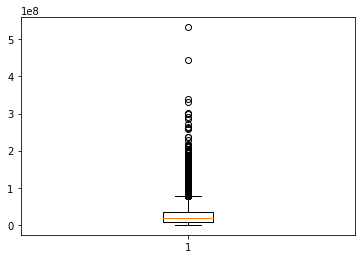

In [307]:
# outlier treatment for Amount
plt.boxplot(data_process.MonetaryValue)
Q1 = data_process.MonetaryValue.quantile(0.25)
Q3 = data_process.MonetaryValue.quantile(0.75)
IQR = Q3 - Q1
data_noOut = data_process[(data_process.MonetaryValue >= (Q1 - 1.5*IQR)) & (data_process.MonetaryValue <= (Q3 + 1.5*IQR))]

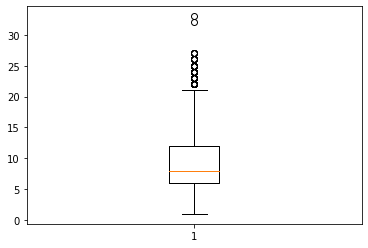

In [308]:
# outlier treatment for Frequency
plt.boxplot(data_noOut.Frequency)
Q1 = data_noOut.Frequency.quantile(0.25)
Q3 = data_noOut.Frequency.quantile(0.75)
IQR = Q3 - Q1
data_noOut = data_noOut[(data_noOut.Frequency >= Q1 - 1.5*IQR) & (data_noOut.Frequency <= Q3 + 1.5*IQR)]

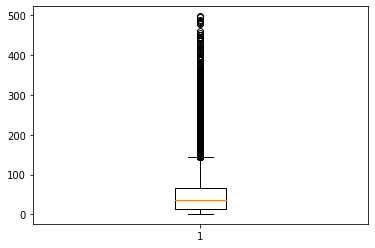

In [309]:
# outlier treatment for Recency
plt.boxplot(data_noOut.Recency)
Q1 = data_noOut.Recency.quantile(0.25)
Q3 = data_noOut.Recency.quantile(0.75)
IQR = Q3 - Q1
data_noOut = data_noOut[(data_noOut.Recency >= Q1 - 1.5*IQR) & (data_noOut.Recency <= Q3 + 1.5*IQR)]

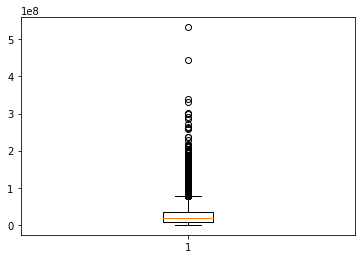

In [310]:
# outlier treatment for Amount
plt.boxplot(data_process_id.MonetaryValue)
Q1 = data_process_id.MonetaryValue.quantile(0.25)
Q3 = data_process_id.MonetaryValue.quantile(0.75)
IQR = Q3 - Q1
data_process_id_id_out = data_process_id[(data_process_id.MonetaryValue >= (Q1 - 1.5*IQR)) & (data_process_id.MonetaryValue <= (Q3 + 1.5*IQR))]

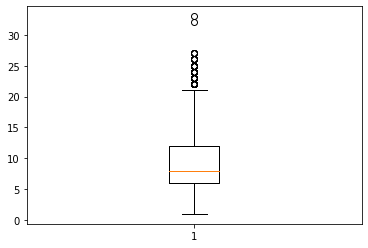

In [311]:
# outlier treatment for Frequency
plt.boxplot(data_process_id_id_out.Frequency)
Q1 = data_process_id_id_out.Frequency.quantile(0.25)
Q3 = data_process_id_id_out.Frequency.quantile(0.75)
IQR = Q3 - Q1
data_process_id_id_out = data_process_id_id_out[(data_process_id_id_out.Frequency >= Q1 - 1.5*IQR) & (data_process_id_id_out.Frequency <= Q3 + 1.5*IQR)]

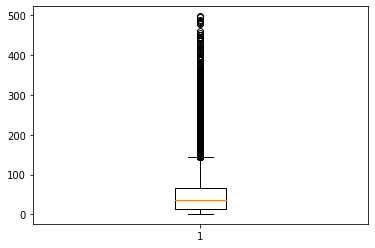

In [312]:
# outlier treatment for Recency
plt.boxplot(data_process_id_id_out.Recency)
Q1 = data_process_id_id_out.Recency.quantile(0.25)
Q3 = data_process_id_id_out.Recency.quantile(0.75)
IQR = Q3 - Q1
data_process_id_id_out = data_process_id_id_out[(data_process_id_id_out.Recency >= Q1 - 1.5*IQR) & (data_process_id_id_out.Recency <= Q3 + 1.5*IQR)]

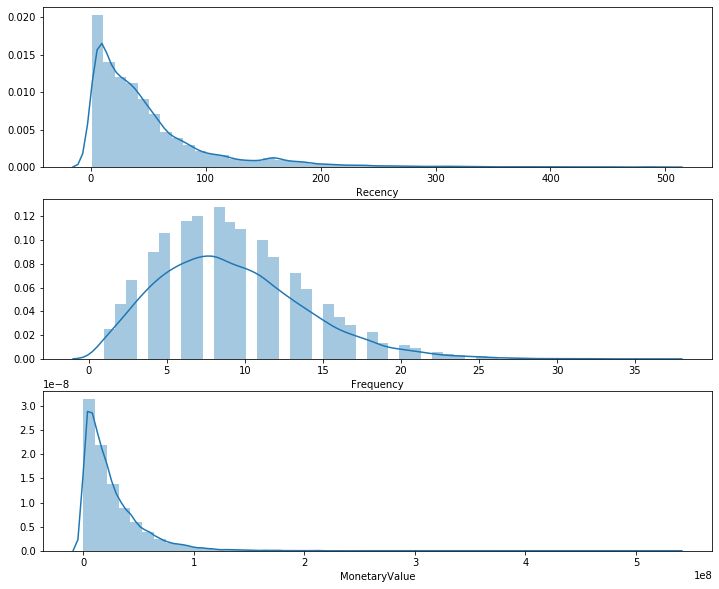

In [287]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

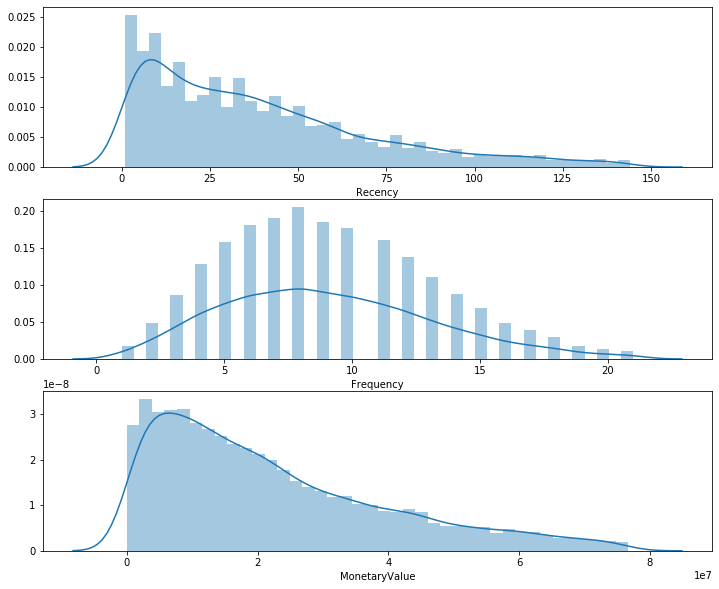

In [288]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_noOut['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_noOut['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_noOut['MonetaryValue'])
# Show the plot
plt.show()

# Quantile Method

In [80]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
# Create new columns R and F 
data_process_RFM = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process_RFM.head()

Recency  Frequency  MonetaryValue  R  F
0        3         18       70050000  4  4
1      111          1         143000  1  1
2       27          8       12204000  3  2
3       36          1          56000  2  1
4      252          1        1071000  1  1

In [81]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to four equal percentile groups 
m_groups = pd.qcut(data_process_RFM['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process_RFM = data_process_RFM.assign(M = m_groups.values)

In [82]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process_RFM['RFM_Segment_Concat'] = data_process_RFM.apply(join_rfm, axis=1)
rfm = data_process_RFM
rfm.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment_Concat
0        3         18       70050000  4  4  4                444
1      111          1         143000  1  1  1                111
2       27          8       12204000  3  2  2                322
3       36          1          56000  2  1  1                211
4      252          1        1071000  1  1  1                111

In [83]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())

63


In [84]:
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

0    12
1     3
2     7
3     4
4     3
Name: RFM_Score, dtype: int64


In [85]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

Recency  Frequency  MonetaryValue  R  F  M RFM_Segment_Concat  RFM_Score  \
0        3         18       70050000  4  4  4                444         12   
1      111          1         143000  1  1  1                111          3   
2       27          8       12204000  3  2  2                322          7   
3       36          1          56000  2  1  1                211          4   
4      252          1        1071000  1  1  1                111          3   

            RFM_Level  
0               Loyal  
1  Require Activation  
2           Potential  
3     Needs Attention  
4  Require Activation

In [86]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Loyal                 17.8      14.7    54303840.6  4465
Needs Attention       72.4       5.4     8132186.6  3188
Potential             38.1       8.9    22232009.2  8359
Require Activation   154.9       3.4     2856958.3  1714


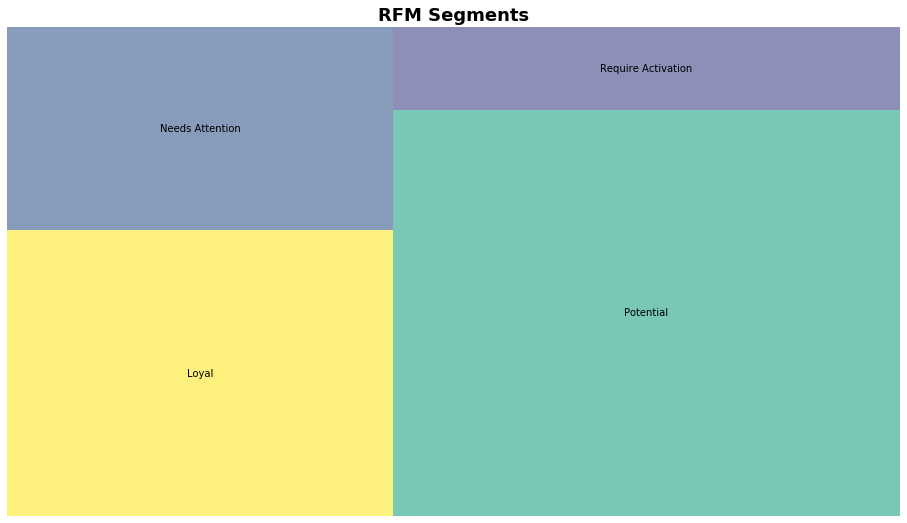

In [87]:
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [88]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(rfm.RFM_Level.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = rfm[rfm.RFM_Level == C]['MonetaryValue'],
                                y = rfm[rfm.RFM_Level == C]['Frequency'],
                                z = rfm[rfm.RFM_Level == C]['Recency'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'MonetaryValue', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Recency', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

# Quantile Method (w/ Handling Outlier)

In [89]:
#Quantile

# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_noOut['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_noOut['Frequency'], q=4, labels=f_labels)
# Create new columns R and F 
data_noOut_RFM = data_noOut.assign(R = r_groups.values, F = f_groups.values)
data_noOut_RFM.head()

# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to four equal percentile groups 
m_groups = pd.qcut(data_noOut_RFM['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_noOut_RFM = data_noOut_RFM.assign(M = m_groups.values)

# Concat RFM quartile values to create RFM Segments
def join_rfm_no(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_noOut_RFM['RFM_Segment_Concat'] = data_noOut_RFM.apply(join_rfm_no, axis=1)
rfm_no = data_noOut_RFM

# Calculate RFM_Score
rfm_no['RFM_Score'] = rfm_no[['R','F','M']].sum(axis=1)

# Define rfm_no_level function
def rfm_no_level(df):
    if df['RFM_Score'] >= 10:
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 6)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm_no['RFM_Level'] = rfm_no.apply(rfm_no_level, axis=1)

In [90]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_no_level_agg = rfm_no.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_no_level_agg)

                   Recency Frequency MonetaryValue      
                      mean      mean          mean count
RFM_Level                                               
Loyal                 16.5      13.8    42001448.9  3541
Needs Attention       57.3       5.6     7971231.8  2887
Potential             35.2       9.0    21279088.1  7881
Require Activation    90.4       3.9     3429361.0  1081


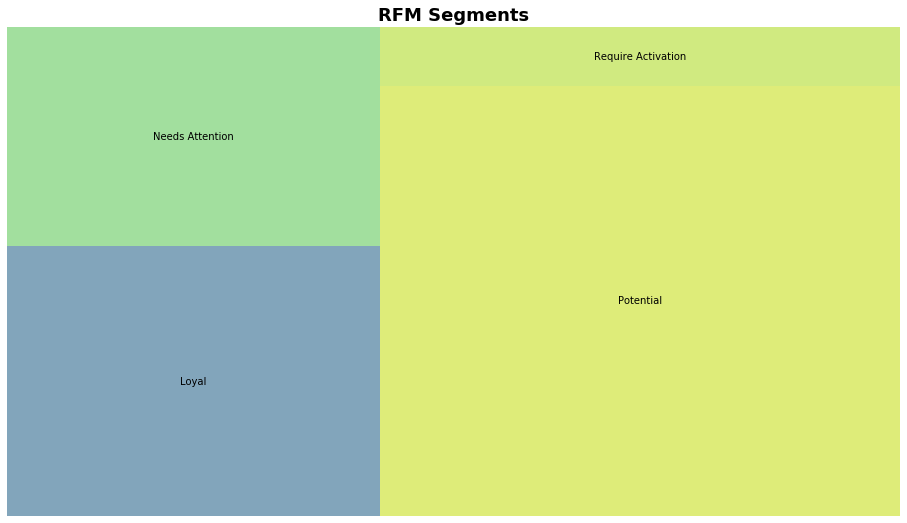

In [91]:
rfm_no_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_no_level_agg['Count'], 
              label=['Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [92]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(rfm_no.RFM_Level.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = rfm_no[rfm_no.RFM_Level == C]['MonetaryValue'],
                                y = rfm_no[rfm_no.RFM_Level == C]['Frequency'],
                                z = rfm_no[rfm_no.RFM_Level == C]['Recency'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'MonetaryValue', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Recency', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

# K Means

In [93]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler = MinMaxScaler()
RFM_norm1 = MinMaxScaler.fit_transform(data_process)

In [94]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Recency','Frequency','MonetaryValue']
RFM_norm1.head()

Recency  Frequency  MonetaryValue
0  0.004024   0.485714       0.131584
1  0.221328   0.000000       0.000263
2  0.052314   0.200000       0.022920
3  0.070423   0.000000       0.000100
4  0.505030   0.000000       0.002006

In [43]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [44]:
hopkins(RFM_norm1)

0.9919267391176138

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [45]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

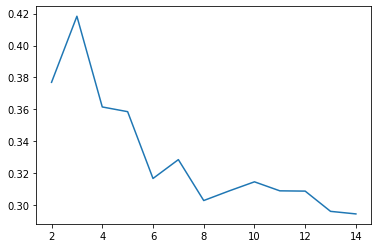

In [46]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

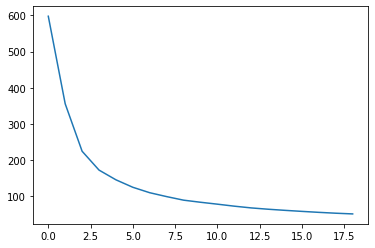

In [47]:
# sum of squared distances
ssd = []
for num_clusters in range(1,20):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.

In [95]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3, max_iter=500)
model_clus3.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [96]:
pd.RangeIndex(len(data_process.index))

RangeIndex(start=0, stop=17726, step=1)

In [97]:
# analysis of clusters formed
data_process.index = pd.RangeIndex(len(data_process.index))
RFM_km = pd.concat([data_process, pd.Series(model_clus3.labels_)], axis=1)
RFM_km.columns = ['Recency', 'Frequency', 'MonetaryValue', 'ClusterID']

km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).MonetaryValue.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [98]:
km_clusters_amount

MonetaryValue
ClusterID               
0           1.611012e+07
1           4.694401e+07
2           9.022934e+06

In [99]:
RFM_km.head()

Recency  Frequency  MonetaryValue  ClusterID
0        3         18       70050000          1
1      111          1         143000          2
2       27          8       12204000          0
3       36          1          56000          0
4      252          1        1071000          2

In [100]:
df = pd.concat([pd.Series([0,1,2]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClusterID       3 non-null      int64  
 1   Amount_mean     3 non-null      float64
 2   Frequency_mean  3 non-null      float64
 3   Recency_mean    3 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 224.0 bytes


In [101]:
RFM_km.head()

Recency  Frequency  MonetaryValue  ClusterID
0        3         18       70050000          1
1      111          1         143000          2
2       27          8       12204000          0
3       36          1          56000          0
4      252          1        1071000          2

In [102]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = RFM_km.groupby('ClusterID').agg({
    'MonetaryValue': 'mean',
    'Frequency': 'mean',
    'Recency': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

          MonetaryValue Frequency Recency      
                   mean      mean    mean count
ClusterID                                      
0            16110120.2       6.9    38.0  9667
1            46944008.3      14.4    29.1  6083
2             9022933.7       4.5   176.8  1976


In [103]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(RFM_km.ClusterID.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = RFM_km[RFM_km.ClusterID == C]['MonetaryValue'],
                                y = RFM_km[RFM_km.ClusterID == C]['Frequency'],
                                z = RFM_km[RFM_km.ClusterID == C]['Recency'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'ClusterID ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'MonetaryValue', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Recency', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

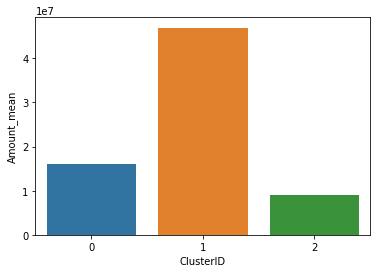

In [104]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

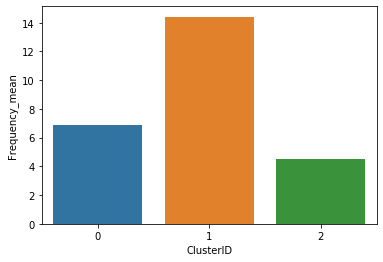

In [105]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

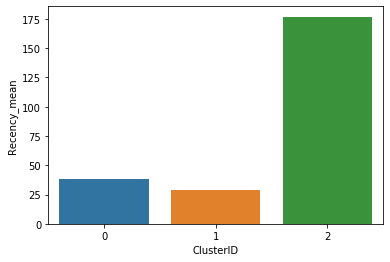

In [106]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

# K Means (w/ handling outlier)

In [313]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler = MinMaxScaler()
RFM_normout1 = MinMaxScaler.fit_transform(data_noOut)

In [314]:
RFM_normout1 = pd.DataFrame(RFM_normout1)
RFM_normout1.columns = ['Recency','Frequency','MonetaryValue']
RFM_normout1.head()

Recency  Frequency  MonetaryValue
0  0.013986       0.85       0.913818
1  0.769231       0.00       0.001813
2  0.181818       0.35       0.159161
3  0.244755       0.00       0.000678
4  0.048951       0.95       0.810038

In [263]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [114]:
hopkins(RFM_normout1)

0.8565203835645219

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [115]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_normout1)
    sse_.append([k, silhouette_score(RFM_normout1, kmeans.labels_)])

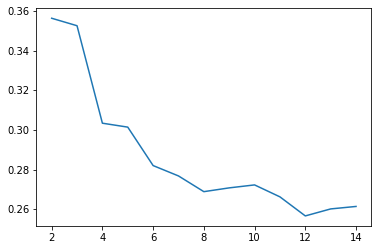

In [116]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

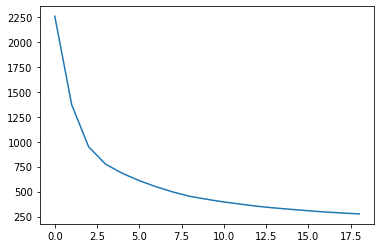

In [117]:
# sum of squared distances
ssd = []
for num_clusters in range(1,20):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_normout1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

The location of a bend (knee) in the plot is generally considered as an indicator of the appropriate number of clusters.

In [315]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3, max_iter=500)
model_clus3.fit(RFM_normout1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [316]:
pd.RangeIndex(len(data_noOut.index))

RangeIndex(start=0, stop=15390, step=1)

In [318]:
# analysis of clusters formed
data_process_id_id_out.index = pd.RangeIndex(len(data_process_id_id_out.index))
RFM_km_out = pd.concat([data_process_id_id_out, pd.Series(model_clus3.labels_)], axis=1)
RFM_km_out.columns = ['Recency', 'Frequency', 'MonetaryValue', 'buyer_id', 'ClusterID']

km_clusters_amount = 	pd.DataFrame(RFM_km_out.groupby(["ClusterID"]).MonetaryValue.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km_out.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km_out.groupby(["ClusterID"]).Recency.mean())

In [122]:
df = pd.concat([pd.Series([0,1,2]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ClusterID       3 non-null      int64  
 1   Amount_mean     3 non-null      float64
 2   Frequency_mean  3 non-null      float64
 3   Recency_mean    3 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 224.0 bytes


In [123]:
RFM_km_out.head()

Recency  Frequency  MonetaryValue  ClusterID
0        3         18       70050000          2
1      111          1         143000          1
2       27          8       12204000          0
3       36          1          56000          0
4        8         20       62095000          2

In [124]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfmout_level_agg = RFM_km_out.groupby('ClusterID').agg({
    'MonetaryValue': 'median',
    'Frequency': 'median',
    'Recency': ['median', 'count']
}).round(1)
# Print the aggregated dataset
print(rfmout_level_agg)

          MonetaryValue Frequency Recency      
                 median    median  median count
ClusterID                                      
0              12036000         7      22  7255
1               9542000         6      82  3286
2              41210000        13      24  4849


In [125]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfmout_level_agg = RFM_km_out.groupby('ClusterID').agg({
    'MonetaryValue': 'mean',
    'Frequency': 'mean',
    'Recency': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfmout_level_agg)

          MonetaryValue Frequency Recency      
                   mean      mean    mean count
ClusterID                                      
0            13015378.2       7.5    24.1  7255
1            12156109.3       6.5    87.2  3286
2            43055509.5      13.2    28.5  4849


In [126]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(RFM_km_out.ClusterID.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = RFM_km_out[RFM_km_out.ClusterID == C]['MonetaryValue'],
                                y = RFM_km_out[RFM_km_out.ClusterID == C]['Frequency'],
                                z = RFM_km_out[RFM_km_out.ClusterID == C]['Recency'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'ClusterID ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'MonetaryValue', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Recency', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

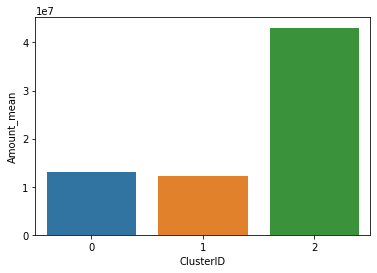

In [127]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

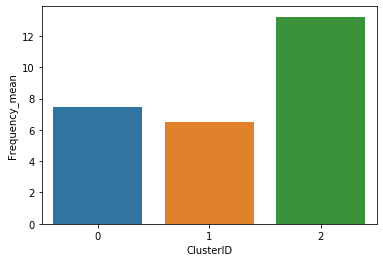

In [128]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

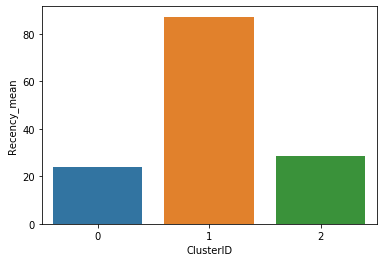

In [129]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

# Hierarchical

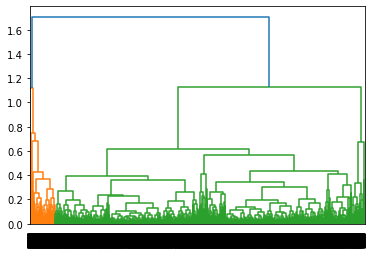

In [130]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [131]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 3).reshape(-1,))
RFM_hc = pd.concat([data_process, clusterCut], axis=1)
RFM_hc.columns = ['Recency', 'Frequency', 'MonetaryValue', 'ClusterID']

In [132]:
#summarise
km_clusters_amount = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).MonetaryValue.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [133]:
df = pd.concat([pd.Series([0,1,2]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

ClusterID   Amount_mean  Frequency_mean  Recency_mean
0          0  7.410234e+07       19.417173     28.268997
1          1  2.284365e+07        8.631005     43.440000
2          2  4.807287e+06        3.046259    238.976871

In [134]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = RFM_hc.groupby('ClusterID').agg({
    'MonetaryValue': 'mean',
    'Frequency': 'mean',
    'Recency': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

          MonetaryValue Frequency Recency       
                   mean      mean    mean  count
ClusterID                                       
0            74102340.7      19.4    28.3   1316
1            22843650.0       8.6    43.4  15675
2             4807287.3       3.0   239.0    735


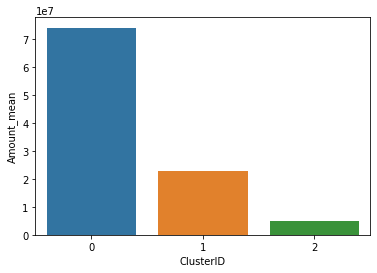

In [135]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

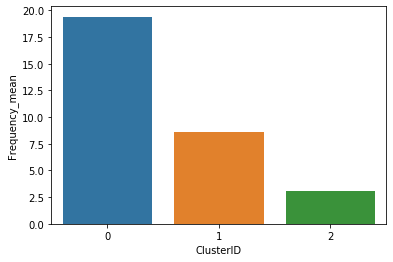

In [136]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

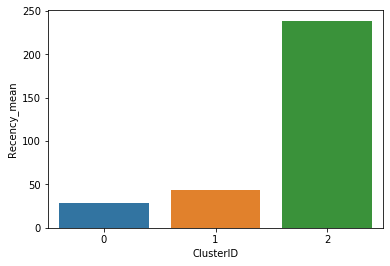

In [137]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

In [138]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(RFM_hc.ClusterID.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = RFM_hc[RFM_hc.ClusterID == C]['MonetaryValue'],
                                y = RFM_hc[RFM_hc.ClusterID == C]['Frequency'],
                                z = RFM_hc[RFM_hc.ClusterID == C]['Recency'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'MonetaryValue', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Recency', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

# Hierarchical (w/ outlier handling)

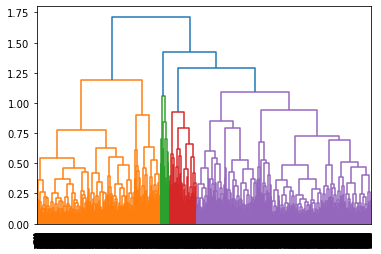

In [139]:
mergings2 = linkage(RFM_normout1, method = "complete", metric='euclidean')
dendrogram(mergings2)
plt.show()

In [140]:
clusterCut2 = pd.Series(cut_tree(mergings2, n_clusters = 3).reshape(-1,))
rfmout_hc = pd.concat([data_noOut, clusterCut2], axis=1)
rfmout_hc.columns = ['Recency', 'Frequency', 'MonetaryValue', 'ClusterID']

In [141]:
#summarise
km_clusters_amount = 	pd.DataFrame(rfmout_hc.groupby(["ClusterID"]).MonetaryValue.mean())
km_clusters_frequency = 	pd.DataFrame(rfmout_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(rfmout_hc.groupby(["ClusterID"]).Recency.mean())

In [142]:
df = pd.concat([pd.Series([0,1,2]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

ClusterID   Amount_mean  Frequency_mean  Recency_mean
0          0  2.975741e+07       11.038731     23.367677
1          1  8.894734e+06        5.772791     59.735098
2          2  3.978584e+07       10.671463    101.175060

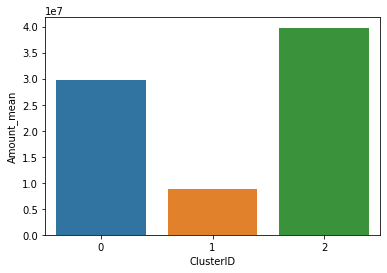

In [143]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

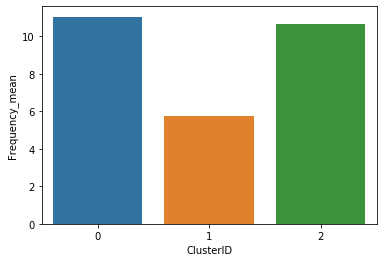

In [144]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

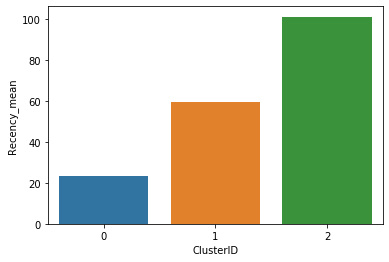

In [145]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

In [146]:
import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(rfmout_hc.ClusterID.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = rfmout_hc[rfmout_hc.ClusterID == C]['MonetaryValue'],
                                y = rfmout_hc[rfmout_hc.ClusterID == C]['Frequency'],
                                z = rfmout_hc[rfmout_hc.ClusterID == C]['Recency'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'MonetaryValue', titlefont_color = 'black'),
                                yaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                zaxis=dict(title = 'Recency', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

# Validation

In [147]:
#silhouette_score
from sklearn import metrics
s1 = metrics.silhouette_score(data_process, rfm.RFM_Level, metric='manhattan')
print("== Silhouette Score ==")
print("> quantile")
print(s1)
s2 = metrics.silhouette_score(data_process, RFM_km.ClusterID, metric='manhattan')
print("> kmeans")
print(s2)
s3 = metrics.silhouette_score(data_process, RFM_hc.ClusterID, metric='manhattan')
print("> hierarchical")
print(s3)

== Silhouette Score ==
> quantile
-0.07833504360796428
> kmeans
-0.06732764008500867
> hierarchical
-0.18191522035726312


In [148]:
#silhouette_score O
from sklearn import metrics
s1 = metrics.silhouette_score(data_noOut, rfm_no.RFM_Level, metric='manhattan')
print("== Silhouette Score w/ Outlier Handling ==")
print("> quantile")
print(s1)
s2 = metrics.silhouette_score(data_noOut, RFM_km_out.ClusterID, metric='manhattan')
print("> kmeans")
print(s2)
s3 = metrics.silhouette_score(data_noOut, rfmout_hc.ClusterID, metric='manhattan')
print("> hierarchical")
print(s3)

== Silhouette Score w/ Outlier Handling ==
> quantile
-0.09006890644231413
> kmeans
0.13418860298265972
> hierarchical
0.023386088126153334


If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

In [149]:
#Calinski Harabasz
from sklearn import metrics
s1 = metrics.calinski_harabasz_score(data_process, rfm.RFM_Level)
print("== Calinski Harabasz ==")
print("> quantile")
print(s1)
s2 = metrics.calinski_harabasz_score(data_process, RFM_km.ClusterID)
print("> kmeans")
print(s2)
s3 = metrics.calinski_harabasz_score(data_process, RFM_hc.ClusterID)
print("> hierarchical")
print(s3)

== Calinski Harabasz ==
> quantile
4359.618675270559
> kmeans
4083.204477682114
> hierarchical
3215.7270195596534


In [150]:
#Calinski Harabasz
from sklearn import metrics
s1 = metrics.calinski_harabasz_score(data_noOut, rfm_no.RFM_Level)
print("== Calinski Harabasz w/ Outlier Handling ==")
print("> quantile")
print(s1)
s2 = metrics.calinski_harabasz_score(data_noOut, RFM_km_out.ClusterID)
print("> kmeans")
print(s2)
s3 = metrics.calinski_harabasz_score(data_noOut, rfmout_hc.ClusterID)
print("> hierarchical")
print(s3)

== Calinski Harabasz w/ Outlier Handling ==
> quantile
4819.665876391613
> kmeans
12906.533161479694
> hierarchical
4005.2212101052805


If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

In [151]:
#Dunn Index
from sklearn import metrics
s1 = metrics.davies_bouldin_score(data_process, rfm.RFM_Level)
print("== Dunn Index ==")
print("> quantile")
print(s1)
s2 = metrics.davies_bouldin_score(data_process, RFM_km.ClusterID)
print("> kmeans")
print(s2)
s3 = metrics.davies_bouldin_score(data_process, RFM_hc.ClusterID)
print("> hierarchical")
print(s3)

== Dunn Index ==
> quantile
1.1803744466342652
> kmeans
2.130145237769191
> hierarchical
1.026202706631878


In [152]:
#Dunn Index O
from sklearn import metrics
s1 = metrics.davies_bouldin_score(data_noOut, rfm_no.RFM_Level)
print("== Dunn Index w/ Outlier Handling ==")
print("> quantile")
print(s1)
s2 = metrics.davies_bouldin_score(data_noOut, RFM_km_out.ClusterID)
print("> kmeans")
print(s2)
s3 = metrics.davies_bouldin_score(data_noOut, rfmout_hc.ClusterID)
print("> hierarchical")
print(s3)

== Dunn Index w/ Outlier Handling ==
> quantile
1.2689610156602613
> kmeans
11.654081560361556
> hierarchical
1.9545600587247132


If the ground truth labels are not known, the Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters.

This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Zero is the lowest possible score. Values closer to zero indicate a better partition.

# Best Model Results

In [200]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_km_out_agg = RFM_km_out.groupby('ClusterID').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_km_out_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
ClusterID                                      
0            24.1       7.5    13015378.2  7255
1            87.2       6.5    12156109.3  3286
2            28.5      13.2    43055509.5  4849


In [201]:
rfm_km_out_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']

In [202]:
rfm_km_out_agg

RecencyMean  FrequencyMean  MonetaryMean  Count
ClusterID                                                 
0                 24.1            7.5    13015378.2   7255
1                 87.2            6.5    12156109.3   3286
2                 28.5           13.2    43055509.5   4849

In [203]:
rfm_km_out_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RecencyMean    3 non-null      float64
 1   FrequencyMean  3 non-null      float64
 2   MonetaryMean   3 non-null      float64
 3   Count          3 non-null      int64  
dtypes: float64(3), int64(1)
memory usage: 120.0 bytes


In [204]:
rfm_km_out_agg = rfm_km_out_agg.rename(index={'0': 'Potential'})
rfm_km_out_agg = rfm_km_out_agg.rename(index={'1': 'At Risk'})
rfm_km_out_agg = rfm_km_out_agg.rename(index={'2': 'Loyal'})

In [185]:
rfm_km_out_agg

RecencyMean  FrequencyMean  MonetaryMean  Count
ClusterID                                                 
0                 24.1            7.5    13015378.2   7255
1                 87.2            6.5    12156109.3   3286
2                 28.5           13.2    43055509.5   4849

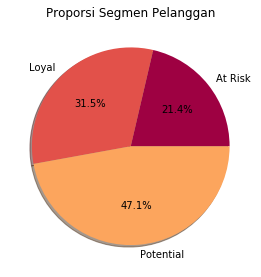

In [195]:
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

type_labels = ['At Risk','Loyal','Potential'] 
type_counts = rfm_km_out_agg.Count.sort_values()

plt.figure(1, figsize=(20,10)) 
the_grid = GridSpec(2, 2)

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.subplot(the_grid[0, 1], aspect=1, title='Proporsi Segmen Pelanggan')
type_show_ids = plt.pie(type_counts, labels=type_labels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

In [323]:
RFM_km_out['ClusterID'].replace(0, 'Potential',inplace=True)
RFM_km_out['ClusterID'].replace(1, 'At Risk',inplace=True)
RFM_km_out['ClusterID'].replace(2, 'Loyal',inplace=True)

In [324]:
RFM_km_out
#0 - Potential
#1 - At Risk
#2 - Loyal

Recency  Frequency  MonetaryValue  buyer_id  ClusterID
0            3         18       70050000         1      Loyal
1          111          1         143000         2    At Risk
2           27          8       12204000         3  Potential
3           36          1          56000         4  Potential
4            8         20       62095000         8      Loyal
...        ...        ...            ...       ...        ...
15385        8          9       17355000     17932  Potential
15386       39         10       55016200     17933      Loyal
15387       41         16       40735000     17934      Loyal
15388       26          5       18170000     17935  Potential
15389      120          6       11998000     17936    At Risk

[15390 rows x 5 columns]

In [325]:
RFM_km_out.to_excel('RFM K-Means.xlsx')